In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd

In [2]:
df = pd.read_csv('Sunspots.csv')
X = df['Monthly Mean Total Sunspot Number'].values

In [3]:
df.set_index('Unnamed: 0')

,Date,Monthly Mean Total Sunspot Number
Unnamed: 0,,
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
...,...,...
3260,2020-09-30,0.6
3261,2020-10-31,14.4
3262,2020-11-30,34.0


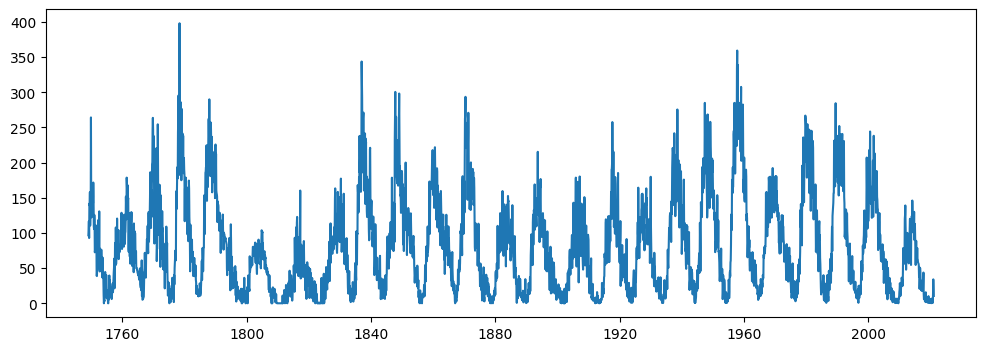

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(pd.to_datetime(df['Date']), df['Monthly Mean Total Sunspot Number'])

In [5]:
# hyperparameters
k = 2
W = 2
w_0 = 4
L = 8

In [6]:
def delay(X, w):
  m = X.shape[0]//w
  n = w if len(X.shape) == 1 else X.shape[1]*w
  _X = np.zeros((m, n))
  for i in range(m):
    _X[i, :] = X[i*w:(i+1)*w].reshape(1, -1)

  return _X

def local_pattern(X, w, k):
  X_w = delay(X, w)
  u, s, v = svd(X_w, full_matrices=False)
  s_matrix = np.diag(s[:k])
  pi = sum(s[k:]**2)/w

  return v[:k].round(2), (u[:, :k] @ s_matrix).round(2), s_matrix.round(2), pi

def hierarchical_svd(X, w_0, W, L, k, verbose=False):
  pi_dict = dict()
  if verbose:
    print(f"original len(X) : {len(X)}")
    print("----------------------------------------------------------------------------")
  V0_ls = []
  V, P, S, pi = local_pattern(X, w_0, k)
  V0_ls.append(V.T)
  pi_dict[w_0] = pi
  if verbose:
    print("【L = 0】")
    print(f"window size        : {w_0}")
    print(f"time-delay         : X → X^(w_0, 0)")
    print(f"time-delay (shape) : ({len(X)}, 1) → ({len(X)//w_0}, {w_0})")
    print(f"SVD                : X^(w_0, 0) = P^(w_0, 0) @ V^(w_0, 0).T")
    print(f"SVD        (shape) : ({len(X)//w_0}, {w_0}) = {P.shape} @ {V.shape}")
    print(f"π                  : {pi}")
    print("----------------------------------------------------------------------------")
  for l in range(1, L):
    w_l = w_0*W**l
    if verbose:
      print(f"【L = {l}】")
      print(f"window size        : {w_l}")
      print(f"time-delay         : P^(w_0, {l-1}) → X^(w_0, {l})")
      print(f"time-delay (shape) : {P.shape} → ({P.shape[0]//W}, {W*P.shape[1]})")
    V, P, S, pi = local_pattern(P, W, k)
    V0_ls.append(np.zeros((w_l, k)))
    pi_dict[w_l] = pi
    for i in range(k):
      for j in range(W):
        V0_ls[l][:, i][j*w_l//W: (j+1)*w_l//W] = V0_ls[l-1]@V.T[:, i][j*k: (j+1)*k]
    if verbose:
      print(f"SVD                : X^(w_0, {l}) = P^(w_0, {l}) @ V^(w_0, {l}).T")
      print(f"SVD        (shape) : ({P.shape[0]}, {P.shape[1]*W}) = {P.shape} @ {V.shape}")
      print(f"π                  : {pi}")
      print("----------------------------------------------------------------------------")

  return P, V0_ls[-1], pi_dict

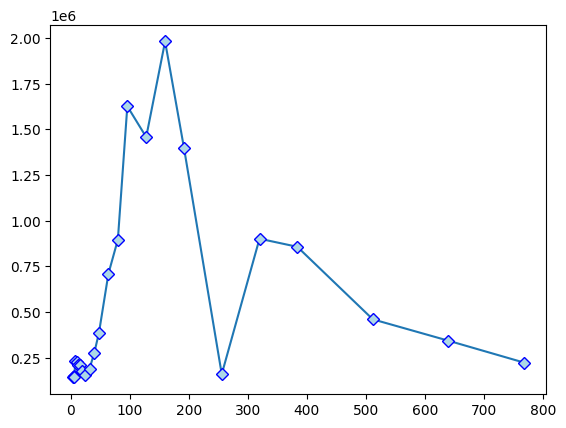

In [7]:
# Power Profile
pi_dict = dict()
for w_0 in [4, 5, 6]:
  for k in [1, 2]:
    _, _, _pi_dict = hierarchical_svd(X, w_0, W, L, k)
    pi_dict.update(_pi_dict)
pi_dict = dict(sorted(pi_dict.items()))
plt.plot(pi_dict.keys(), pi_dict.values(), marker="D", markeredgecolor="blue", markerfacecolor="lightblue")

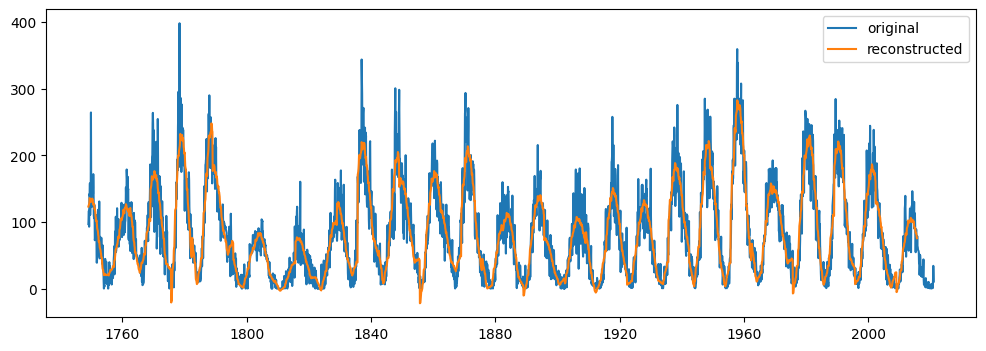

In [8]:
# reconstruction
P, V0, _ = hierarchical_svd(X=X, w_0=5, W=W, L=5, k=3)
X_re = (P@V0.T).flatten()

plt.figure(figsize=(12, 4))
plt.plot(pd.to_datetime(df['Date']), df['Monthly Mean Total Sunspot Number'], label='original')
plt.plot(pd.to_datetime(df['Date'])[:len(X_re)], X_re, label='reconstructed')
plt.legend()

In [14]:
# Figure.5
x = np.arange(0, 2000, 1)
sin_wave = np.sin(2*np.pi*x/50)
noise = np.random.normal(loc=5, scale=0.5, size=len(sin_wave))

In [12]:
pi_list = []
for w in range(5, 401):
  _, _, _, pi = local_pattern(sin_wave+noise, w, 2)
  pi_list.append(pi)

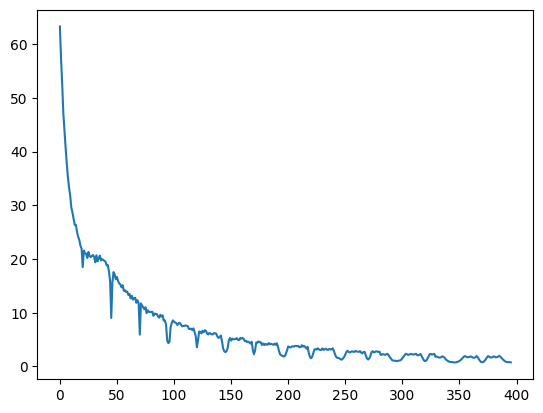

In [13]:
plt.plot(pi_list)